# Elderly Fall Detection using CNN-LSTM with Attention Layer

This notebook trains a deep learning model for detecting elderly falls using accelerometer and gyroscope data. The trained model will be optimized for deployment on ESP32-S3 microcontroller.

## Dataset Structure
- **Falls**: 2,791 samples
- **Walking**: 2,838 samples
- **Running**: Various samples
- **Stand Up**: Various samples
- **Driving**: Various samples

Each sample contains 801 time steps with 9 features:
- AccX, AccY, AccZ (accelerometer)
- GyroX, GyroY, GyroZ (gyroscope)
- Magnitude, Temperature, Altitude

## 1. Setup and Installation

First, let's install required packages and setup the environment for Google Colab.

In [ ]:
# Install required packages
!pip install tensorflow==2.13.0
!pip install tensorflow-model-optimization==0.7.0
!pip install numpy==1.26.0 scikit-learn seaborn

  Using cached numpy-1.26.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached numpy-1.26.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.13.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
nibabel 5.3.2 requires typing-extensions>=4.6; python

In [ ]:
# For ESP32 deployment
!pip install tflite-runtime

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
import glob
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
# Check if GPU is available using the recommended method
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU Available: {len(gpu_devices) > 0}")
print(f"GPU Devices: {gpu_devices}")

TensorFlow version: 2.13.0
GPU Available: False
GPU Devices: []


## 2. Mount Google Drive and Upload Dataset

Upload your 'Dataset V4' folder to Google Drive and mount it here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Update this path to where you uploaded your dataset in Google Drive
DATASET_PATH = '/content/drive/MyDrive/Dataset V4'

# Verify dataset exists
if os.path.exists(DATASET_PATH):
    print("Dataset found!")
    categories = os.listdir(DATASET_PATH)
    print(f"Categories: {categories}")

    for category in categories:
        if os.path.isdir(os.path.join(DATASET_PATH, category)):
            count = len(glob.glob(os.path.join(DATASET_PATH, category, '*.csv')))
            print(f"{category}: {count} files")
else:
    print("Dataset not found. Please upload 'Dataset V4' to your Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset found!
Categories: ['Falls', 'Running', 'Driving', 'Stand Up', 'Walking']
Falls: 2801 files
Running: 1141 files
Driving: 174 files
Stand Up: 2012 files
Walking: 2848 files


## 3. Data Loading and Preprocessing

In [ ]:
def load_sensor_data(dataset_path, max_samples_per_class=None, sequence_length=801):
    """
    Load and preprocess sensor data from CSV files

    Args:
        dataset_path: Path to dataset directory
        max_samples_per_class: Maximum samples per activity class (None for all)
        sequence_length: Number of time steps per sequence

    Returns:
        X: Feature data (samples, time_steps, features)
        y: Labels
        label_encoder: Fitted label encoder
    """

    X = []
    y = []

    # Define activity categories
    categories = ['Falls', 'Walking', 'Running', 'Stand Up', 'Driving']

    print("Loading data...")

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"Warning: {category} folder not found")
            continue

        csv_files = glob.glob(os.path.join(category_path, '*.csv'))

        if max_samples_per_class:
            csv_files = csv_files[:max_samples_per_class]

        print(f"Processing {category}: {len(csv_files)} files")

        for i, file_path in enumerate(csv_files):
            try:
                # Read CSV file
                df = pd.read_csv(file_path)

                # Select relevant sensor features
                feature_columns = ['AccX', 'AccY', 'AccZ','GyroX', 'GyroY', 'GyroZ', 'Altitude']

                # Ensure all columns exist
                available_columns = [col for col in feature_columns if col in df.columns]

                if len(available_columns) < 6:  # At least acc and gyro data
                    print(f"Warning: Insufficient features in {file_path}")
                    continue

                # Extract features
                features = df[available_columns].values

                # Pad or truncate to fixed sequence length
                if len(features) > sequence_length:
                    features = features[:sequence_length]
                elif len(features) < sequence_length:
                    padding = np.zeros((sequence_length - len(features), len(available_columns)))
                    features = np.vstack([features, padding])

                # Handle NaN values
                features = np.nan_to_num(features, nan=0.0)

                X.append(features)
                y.append(category)

                if (i + 1) % 100 == 0:
                    print(f"  Processed {i + 1}/{len(csv_files)} files")

            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")
                continue

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"\nData loading completed:")
    print(f"Total samples: {len(X)}")
    print(f"Input shape: {X.shape}")
    print(f"Classes: {label_encoder.classes_}")
    print(f"Class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  {cls}: {count} samples")

    return X, y_encoded, label_encoder

In [ ]:
# Load the dataset
# Reduce max_samples_per_class for faster training during development
X, y, label_encoder = load_sensor_data(
    DATASET_PATH,
    max_samples_per_class=None,  # Increase this or set to None for full dataset
    sequence_length=801
)

print(f"\nFinal dataset shape: {X.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Features per timestep: {X.shape[2]}")

Loading data...
Processing Falls: 2801 files
  Processed 100/2801 files
  Processed 200/2801 files
  Processed 300/2801 files
  Processed 400/2801 files
  Processed 500/2801 files
  Processed 600/2801 files
  Processed 700/2801 files
  Processed 800/2801 files
  Processed 900/2801 files
  Processed 1000/2801 files
  Processed 1100/2801 files
  Processed 1200/2801 files
  Processed 1300/2801 files
  Processed 1400/2801 files
  Processed 1500/2801 files
  Processed 1600/2801 files
  Processed 1700/2801 files
  Processed 1800/2801 files
  Processed 1900/2801 files
  Processed 2000/2801 files
  Processed 2100/2801 files
  Processed 2200/2801 files
  Processed 2300/2801 files
  Processed 2400/2801 files
  Processed 2500/2801 files
  Processed 2600/2801 files
  Processed 2700/2801 files
  Processed 2800/2801 files
Processing Walking: 2848 files
  Processed 100/2848 files
  Processed 200/2848 files
  Processed 300/2848 files
  Processed 400/2848 files
  Processed 500/2848 files
  Processed 60

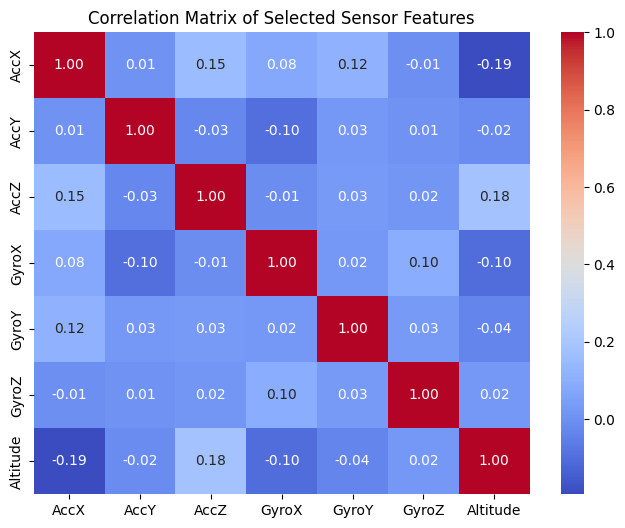

In [ ]:
# Calculate and visualize the correlation matrix for selected features
feature_columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Altitude']
correlation_matrix= df[feature_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Sensor Features')
plt.show()

## 4. Data Preprocessing and Normalization

In [ ]:
# Normalize the data
def normalize_data(X_train, X_val, X_test):
    """
    Normalize the sensor data using StandardScaler
    """
    # Reshape for scaling (samples * timesteps, features)
    original_shape = X_train.shape
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

    # Fit scaler on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    # Reshape back to original shape
    X_train_scaled = X_train_scaled.reshape(original_shape)
    X_val_scaled = X_val_scaled.reshape(X_val.shape)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Normalize the data
X_train_scaled, X_val_scaled, X_test_scaled, scaler = normalize_data(X_train, X_val, X_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"\nNormalized data shapes:")
print(f"X_train: {X_train_scaled.shape}")
print(f"y_train: {y_train_cat.shape}")
print(f"Number of classes: {num_classes}")

Training set: (5364, 801, 7)
Validation set: (1788, 801, 7)
Test set: (1789, 801, 7)

Normalized data shapes:
X_train: (5364, 801, 7)
y_train: (5364, 5)
Number of classes: 5


## 5. CNN-LSTM Model with Attention Layer

We'll create a hybrid model combining:
- **CNN layers**: For extracting local temporal patterns
- **LSTM layers**: For capturing long-term dependencies
- **Attention mechanism**: For focusing on important time steps
- **Optimization for ESP32**: Reduced complexity for deployment

In [ ]:
# Custom Attention Layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], 1),
            initializer='random_normal',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, features)
        # Compute attention scores
        attention_scores = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)

        # Apply attention weights
        weighted_input = inputs * attention_weights
        output = tf.reduce_sum(weighted_input, axis=1)

        return output

    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [ ]:
def create_cnn_lstm_attention_model(input_shape, num_classes, esp32_optimized=True):
    """
    Create CNN-LSTM model with attention layer

    Args:
        input_shape: Shape of input data (time_steps, features)
        num_classes: Number of output classes
        esp32_optimized: If True, use smaller model for ESP32 deployment
    """

    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=input_shape))

    if esp32_optimized:
        # Optimized for ESP32 - smaller model
        # CNN layers for feature extraction
        model.add(layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        # LSTM layers
        model.add(layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
        model.add(layers.LSTM(16, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))

        # Attention layer
        model.add(AttentionLayer())

        # Dense layers
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.5))

    else:
        # Full model for better accuracy
        # CNN layers
        model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        # LSTM layers
        model.add(layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
        model.add(layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))

        # Attention layer
        model.add(AttentionLayer())

        # Dense layers
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create the model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
print(f"Input shape: {input_shape}")

# Create ESP32-optimized model
model = create_cnn_lstm_attention_model(input_shape, num_classes, esp32_optimized=True)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Print model summary
model.summary()

# Calculate model size
param_count = model.count_params()
print(f"\nTotal parameters: {param_count:,}")
print(f"Estimated model size: ~{param_count * 4 / 1024 / 1024:.2f} MB (32-bit floats)")

Input shape: (801, 7)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 801, 16)           352       
                                                                 
 batch_normalization_4 (Bat  (None, 801, 16)           64        
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 400, 16)           0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 400, 16)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 400, 32)           1568      
                                                                 
 batch_normalization_5 (Bat  (No

## 6. Model Training

In [ ]:
# Create callbacks for training
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_fall_detection_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

# Train the model
print("Starting model training...")
print(f"Training samples: {len(X_train_scaled)}")
print(f"Validation samples: {len(X_val_scaled)}")

# Training parameters
EPOCHS = 200
BATCH_SIZE = 32

# Use explicit metric objects to avoid potential type errors
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Start training
history = model.fit(
    X_train_scaled, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_scaled, y_val_cat),
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining completed!")

Starting model training...
Training samples: 5364
Validation samples: 1788
Epoch 1/200
168/168 [==============================] - 89s 485ms/step - loss: 0.2572 - accuracy: 0.9271 - precision_7: 0.9418 - recall_7: 0.9109 - val_loss: 0.1781 - val_accuracy: 0.9441 - val_precision_7: 0.9475 - val_recall_7: 0.9390 - lr: 0.0010
Epoch 2/200
168/168 [==============================] - 78s 462ms/step - loss: 0.2259 - accuracy: 0.9323 - precision_7: 0.9433 - recall_7: 0.9185 - val_loss: 0.1520 - val_accuracy: 0.9592 - val_precision_7: 0.9622 - val_recall_7: 0.9541 - lr: 0.0010
Epoch 3/200
168/168 [==============================] - 81s 485ms/step - loss: 0.2222 - accuracy: 0.9312 - precision_7: 0.9446 - recall_7: 0.9195 - val_loss: 0.1658 - val_accuracy: 0.9463 - val_precision_7: 0.9510 - val_recall_7: 0.9435 - lr: 0.0010
Epoch 4/200
168/168 [==============================] - 80s 476ms/step - loss: 0.2089 - accuracy: 0.9353 - precision_7: 0.9496 - recall_7: 0.9232 - val_loss: 0.1553 - val_accuracy

## 7. Model Evaluation and Visualization

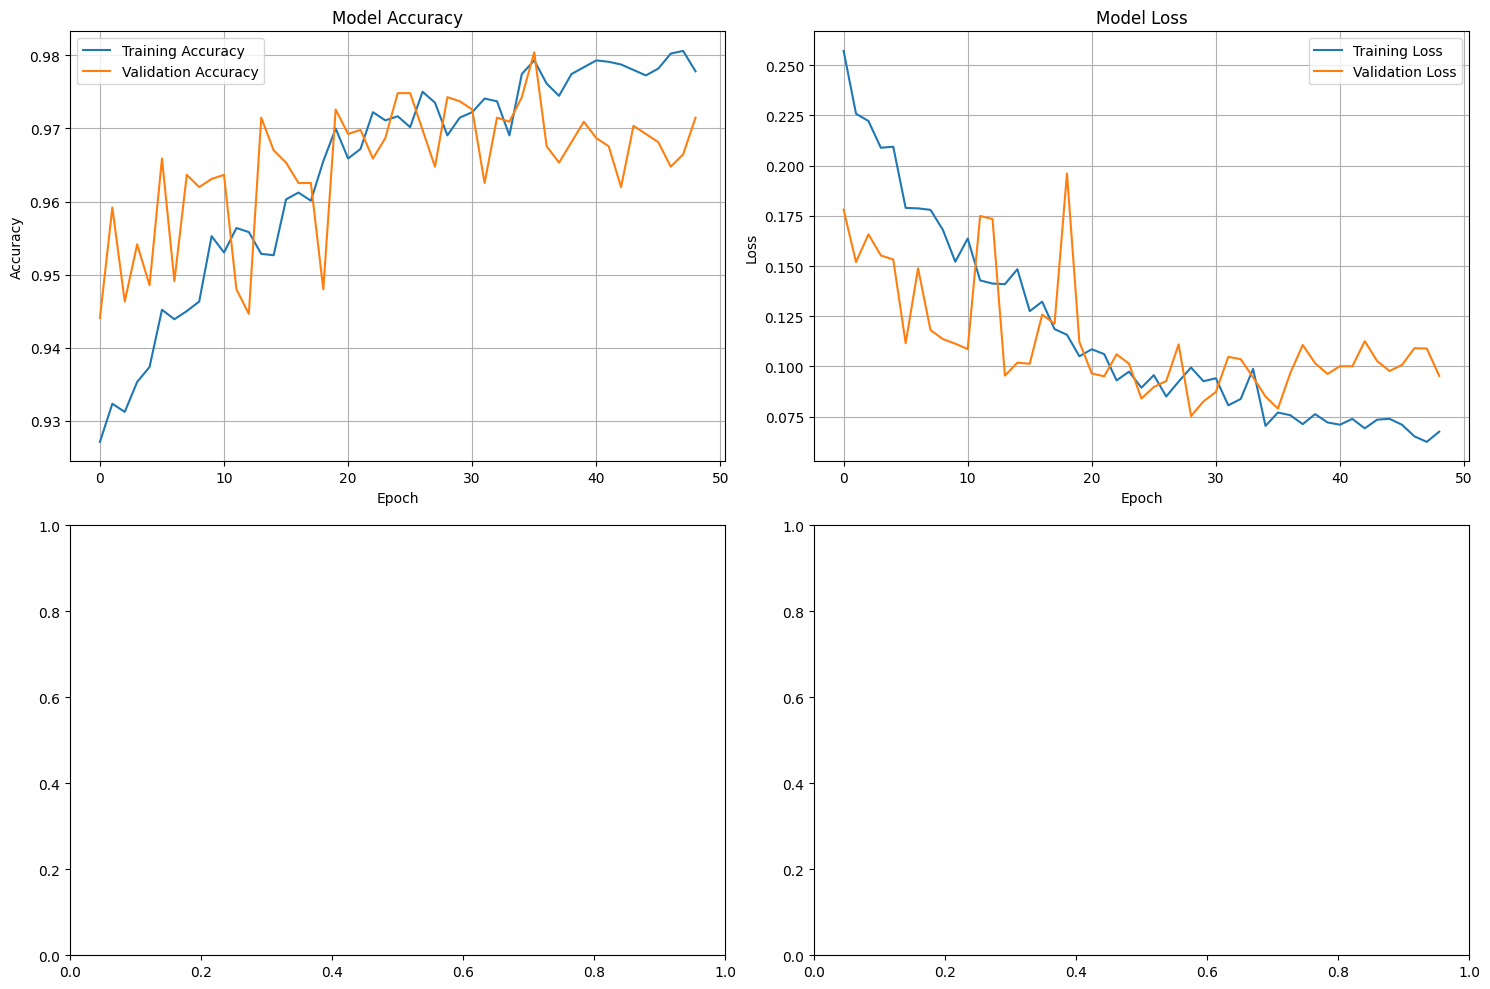

Test Results:
Test Accuracy: 0.9698
Test Precision: 0.9746
Test Recall: 0.9659
Test Loss: 0.0938
56/56 [==============================] - 4s 53ms/step

Classification Report:
              precision    recall  f1-score   support

     Driving       0.79      0.86      0.82        35
       Falls       0.98      0.96      0.97       560
     Running       0.96      0.98      0.97       228
    Stand Up       0.96      0.98      0.97       397
     Walking       0.99      0.97      0.98       569

    accuracy                           0.97      1789
   macro avg       0.93      0.95      0.94      1789
weighted avg       0.97      0.97      0.97      1789



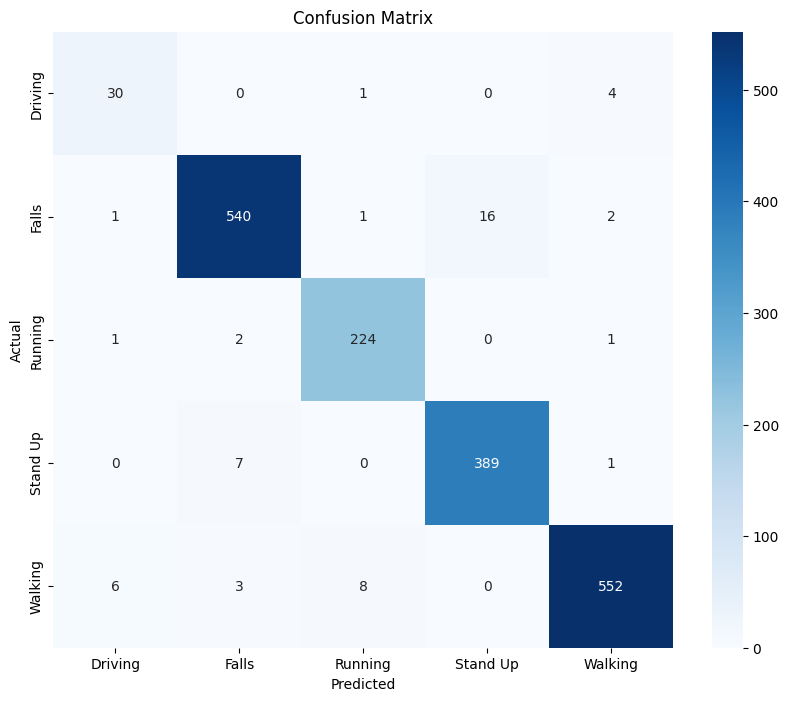

In [ ]:
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # Recall
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Load the best model and evaluate on test set
model.load_weights('best_fall_detection_model.h5')

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_test_scaled, y_test_cat, verbose=0
)

print(f"Test Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=label_encoder.classes_
))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Model Conversion for ESP32-S3

Convert the trained model to TensorFlow Lite format for deployment on ESP32-S3.

In [ ]:
# Convert model to TensorFlow Lite
def convert_to_tflite(model, model_name="fall_detection_model"):
    """
    Convert Keras model to TensorFlow Lite format
    """
    # Basic conversion
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Apply optimizations for microcontroller deployment
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Recommended settings from error message
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False


    # Try quantization for smaller size
    try:
        # Representative dataset for quantization
        def representative_dataset():
            for i in range(min(100, len(X_train_scaled))):
                data = X_train_scaled[i:i+1].astype(np.float32)
                yield [data]

        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_types = [tf.int8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8

        tflite_model = converter.convert()
        filename = f'{model_name}_quantized.tflite'

    except Exception as e:
        print(f"Quantized conversion failed: {e}")
        print("Using basic conversion...")

        # Fallback to basic conversion with recommended settings
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        converter._experimental_lower_tensor_list_ops = False


        tflite_model = converter.convert()
        filename = f'{model_name}_basic.tflite'

    # Save the model
    with open(filename, 'wb') as f:
        f.write(tflite_model)

    print(f"TFLite model saved as {filename}")
    print(f"Model size: {len(tflite_model) / 1024:.2f} KB")

    return tflite_model, filename

# Convert the model
tflite_model, tflite_filename = convert_to_tflite(model, "elderly_fall_detection")

# Test TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\nTFLite Model Details:")
print(f"Input shape: {input_details[0]['shape']}")
print(f"Input type: {input_details[0]['dtype']}")
print(f"Output shape: {output_details[0]['shape']}")
print(f"Output type: {output_details[0]['dtype']}")

Quantized conversion failed: /usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/save.py:1313:0: error: 'tf.TensorListReserve' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/save.py:1313:0: note: Error code: ERROR_NEEDS_FLEX_OPS
/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/save.py:1313:0: error: 'tf.TensorListStack' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/save.py:1313:0: note: Error code: ERROR_NEEDS_FLEX_OPS
/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/save.py:1313:0: error: 'tf.TensorListReserve' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "S

## 9. Generate Arduino Code for ESP32-S3

In [ ]:
# Convert TFLite model to C header file
def tflite_to_header(tflite_model, header_name="model_data"):
    """
    Convert TFLite model to C header file for Arduino
    """
    model_size = len(tflite_model)

    header_content = f'''
#ifndef {header_name.upper()}_H_
#define {header_name.upper()}_H_

// Elderly Fall Detection Model
// Generated from TensorFlow Lite model
// Model size: {model_size} bytes

const unsigned int {header_name}_len = {model_size};
const unsigned char {header_name}[] = {{
'''

    # Convert model bytes to hex format
    hex_data = []
    for i, byte in enumerate(tflite_model):
        if i % 16 == 0:
            hex_data.append('\n  ')
        hex_data.append(f'0x{byte:02x}, ')

    header_content += ''.join(hex_data)[:-2]  # Remove last comma and space
    header_content += f'''
}};

#endif  // {header_name.upper()}_H_
'''

    return header_content

# Convert model to header file
header_content = tflite_to_header(tflite_model, "fall_detection_model")

with open('fall_detection_model.h', 'w') as f:
    f.write(header_content)

print(f"Model header file saved as 'fall_detection_model.h'")
print(f"Model size: {len(tflite_model)} bytes ({len(tflite_model)/1024:.2f} KB)")

Model header file saved as 'fall_detection_model.h'
Model size: 63560 bytes (62.07 KB)


In [ ]:
# Generate complete Arduino code for ESP32-S3
arduino_code_template = '''
/*
  Elderly Fall Detection using CNN-LSTM with Attention
  ESP32-S3 Implementation

  This code implements a fall detection system using the trained model.
  The model processes accelerometer and gyroscope data to detect falls.
*/

#include <TensorFlowLite_ESP32.h>
#include <tensorflow/lite/micro/all_ops_resolver.h>
#include <tensorflow/lite/micro/micro_error_reporter.h>
#include <tensorflow/lite/micro/micro_interpreter.h>
#include <tensorflow/lite/schema/schema_generated.h>
#include <tensorflow/lite/version.h>
#include <Wire.h>
#include <MPU6050.h>
#include "fall_detection_model.h"

// Model and inference constants
const int SEQUENCE_LENGTH = {sequence_length};
const int FEATURES_PER_STEP = {features_per_step};
const int NUM_CLASSES = {num_classes};
const int TENSOR_ARENA_SIZE = 70000;

// Activity labels
const char* ACTIVITY_LABELS[] = {{
{class_labels}
}};

// Sensor and model variables
MPU6050 mpu;
float sensor_buffer[SEQUENCE_LENGTH][FEATURES_PER_STEP];
int buffer_index = 0;
bool buffer_full = false;

// TensorFlow Lite variables
tflite::MicroErrorReporter micro_error_reporter;
tflite::AllOpsResolver resolver;
const tflite::Model* model;
tflite::MicroInterpreter* interpreter;
TfLiteTensor* input;
TfLiteTensor* output;
uint8_t tensor_arena[TENSOR_ARENA_SIZE];

// Normalization parameters from training
float feature_means[FEATURES_PER_STEP] = {{
{feature_means}
}};

float feature_stds[FEATURES_PER_STEP] = {{
{feature_stds}
}};

void setup() {{
  Serial.begin(115200);

  // Initialize I2C and MPU6050
  Wire.begin();
  mpu.initialize();

  if (!mpu.testConnection()) {{
    Serial.println("MPU6050 connection failed!");
    while(1);
  }}

  Serial.println("MPU6050 initialized successfully");

  // Load TensorFlow Lite model
  model = tflite::GetModel(fall_detection_model);
  if (model->version() != TFLITE_SCHEMA_VERSION) {{
    Serial.println("Model schema version mismatch!");
    while(1);
  }}

  // Create interpreter
  interpreter = new tflite::MicroInterpreter(
      model, resolver, tensor_arena, TENSOR_ARENA_SIZE, &micro_error_reporter);

  // Allocate memory for tensors
  TfLiteStatus allocate_status = interpreter->AllocateTensors();
  if (allocate_status != kTfLiteOk) {{
    Serial.println("AllocateTensors() failed!");
    while(1);
  }}

  // Get input and output tensors
  input = interpreter->input(0);
  output = interpreter->output(0);

  Serial.println("Fall Detection System Ready!");
  Serial.printf("Input shape: [%d, %d]\\n", SEQUENCE_LENGTH, FEATURES_PER_STEP);
  Serial.printf("Output classes: %d\\n", NUM_CLASSES);
}}

void loop() {{
  // Read sensor data
  int16_t ax, ay, az, gx, gy, gz;
  mpu.getMotion6(&ax, &ay, &az, &gx, &gy, &gz);

  // Convert to float and scale
  float acc_x = ax / 16384.0; // For ±2g range
  float acc_y = ay / 16384.0;
  float acc_z = az / 16384.0;
  float gyro_x = gx / 131.0;  // For ±250°/s range
  float gyro_y = gy / 131.0;
  float gyro_z = gz / 131.0;

  // Calculate magnitude
  float magnitude = sqrt(acc_x*acc_x + acc_y*acc_y + acc_z*acc_z);

  // Use dummy values for temperature and altitude if not available
  float temperature = 25.0;
  float altitude = 100.0;

  // Store in buffer
  sensor_buffer[buffer_index][0] = acc_x;
  sensor_buffer[buffer_index][1] = acc_y;
  sensor_buffer[buffer_index][2] = acc_z;
  sensor_buffer[buffer_index][3] = magnitude;
  sensor_buffer[buffer_index][4] = gyro_x;
  sensor_buffer[buffer_index][5] = gyro_y;
  sensor_buffer[buffer_index][6] = gyro_z;
  if (FEATURES_PER_STEP > 7) {{
    sensor_buffer[buffer_index][7] = temperature;
  }}
  if (FEATURES_PER_STEP > 8) {{
    sensor_buffer[buffer_index][8] = altitude;
  }}

  buffer_index++;

  if (buffer_index >= SEQUENCE_LENGTH) {{
    buffer_full = true;
    buffer_index = 0;
  }}

  // Run inference when buffer is full
  if (buffer_full) {{
    runInference();
  }}

  delay(10); // Adjust sampling rate as needed
}}

void runInference() {{
  // Normalize and copy data to input tensor
  for (int i = 0; i < SEQUENCE_LENGTH; i++) {{
    for (int j = 0; j < FEATURES_PER_STEP; j++) {{
      int index = i * FEATURES_PER_STEP + j;
      // Apply normalization (z-score)
      float normalized_value = (sensor_buffer[i][j] - feature_means[j]) / feature_stds[j];
      input->data.f[index] = normalized_value;
    }}
  }}

  // Run inference
  TfLiteStatus invoke_status = interpreter->Invoke();
  if (invoke_status != kTfLiteOk) {{
    Serial.println("Invoke failed!");
    return;
  }}

  // Get prediction
  float max_probability = 0;
  int predicted_class = 0;

  for (int i = 0; i < NUM_CLASSES; i++) {{
    float probability = output->data.f[i];
    if (probability > max_probability) {{
      max_probability = probability;
      predicted_class = i;
    }}
  }}

  // Print results
  Serial.printf("Predicted: %s (%.2f%%)\\n",
                ACTIVITY_LABELS[predicted_class],
                max_probability * 100);

  // Special handling for fall detection
  if (strcmp(ACTIVITY_LABELS[predicted_class], "Falls") == 0 && max_probability > 0.7) {{
    Serial.println("*** FALL DETECTED! ***");
    triggerFallAlert();
  }}
}}

void triggerFallAlert() {{
  // Implement your fall alert mechanism here
  Serial.println("Fall alert triggered!");

  // Example: Blink built-in LED
  pinMode(LED_BUILTIN, OUTPUT);
  for (int i = 0; i < 5; i++) {{
    digitalWrite(LED_BUILTIN, HIGH);
    delay(200);
    digitalWrite(LED_BUILTIN, LOW);
    delay(200);
  }}
}}
'''

# Generate the Arduino code with actual values
class_labels_str = ',\n  '.join([f'  "{cls}"' for cls in label_encoder.classes_])
means_str = ',\n  '.join([f'{mean:.6f}' for mean in scaler.mean_])
stds_str = ',\n  '.join([f'{std:.6f}' for std in scaler.scale_])

arduino_code = arduino_code_template.format(
    sequence_length=X_train_scaled.shape[1],
    features_per_step=X_train_scaled.shape[2],
    num_classes=num_classes,
    class_labels=class_labels_str,
    feature_means=means_str,
    feature_stds=stds_str
)

# Save Arduino code
with open('elderly_fall_detection_esp32s3.ino', 'w') as f:
    f.write(arduino_code)

print("Arduino code generated and saved as 'elderly_fall_detection_esp32s3.ino'")

Arduino code generated and saved as 'elderly_fall_detection_esp32s3.ino'


## 10. Deployment Instructions and Summary

### Files Generated:
1. **elderly_fall_detection_esp32s3.ino** - Main Arduino sketch
2. **fall_detection_model.h** - TensorFlow Lite model as C header
3. **best_fall_detection_model.h5** - Keras model (for future retraining)
4. **elderly_fall_detection_*.tflite** - TensorFlow Lite model

### ESP32-S3 Setup Steps:
1. Install ESP32 board support in Arduino IDE
2. Install required libraries:
   - TensorFlowLite_ESP32
   - MPU6050 library
   - Wire library (built-in)
3. Connect MPU6050 to ESP32-S3:
   - VCC → 3.3V
   - GND → GND
   - SDA → GPIO21 (or your preferred I2C SDA pin)
   - SCL → GPIO22 (or your preferred I2C SCL pin)
4. Copy all generated files to your Arduino sketch folder
5. Upload the sketch to ESP32-S3

### Customization Options:
1. Adjust fall detection threshold in Arduino code (currently 0.7)
2. Add additional sensors (temperature, barometer)
3. Implement wireless alerts (WiFi, Bluetooth)
4. Add data logging capabilities
5. Optimize sampling rate for battery life

### Notes:
- The model is optimized for ESP32-S3 deployment
- Fall detection threshold can be adjusted based on requirements
- Consider adding more training data for better accuracy
- Test thoroughly with real-world scenarios

In [ ]:
# Create final summary
print("\n" + "="*60)
print("ELDERLY FALL DETECTION MODEL TRAINING COMPLETED!")
print("="*60)
print(f"Dataset: {len(X)} total samples")
print(f"Model: CNN-LSTM with Attention Layer")
print(f"Target: ESP32-S3 Deployment")
print(f"Model Size: {len(tflite_model)/1024:.1f} KB")
print(f"\nTest Accuracy: {test_accuracy:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")
print("\nGenerated Files:")
print("1. elderly_fall_detection_esp32s3.ino - Arduino sketch")
print("2. fall_detection_model.h - Model header file")
print("3. best_fall_detection_model.h5 - Keras model")
print(f"4. {tflite_filename} - TensorFlow Lite model")
print("\nReady for ESP32-S3 deployment!")
print("="*60)


ELDERLY FALL DETECTION MODEL TRAINING COMPLETED!
Dataset: 8941 total samples
Model: CNN-LSTM with Attention Layer
Target: ESP32-S3 Deployment
Model Size: 62.1 KB

Test Accuracy: 0.970
Test Precision: 0.975
Test Recall: 0.966

Generated Files:
1. elderly_fall_detection_esp32s3.ino - Arduino sketch
2. fall_detection_model.h - Model header file
3. best_fall_detection_model.h5 - Keras model
4. elderly_fall_detection_basic.tflite - TensorFlow Lite model

Ready for ESP32-S3 deployment!




---



---



---



**Reasoning**:
The basic information about the loaded data has been displayed. The next step is to visualize the distribution of activities to understand the class balance.



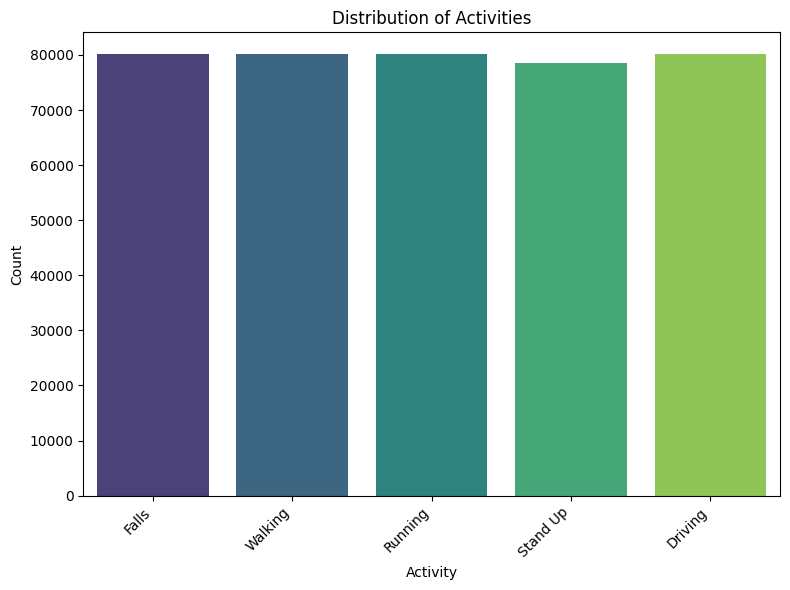

In [ ]:
# Visualize the distribution of activities
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Activity', palette='viridis')
plt.title('Distribution of Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
Visualize the distribution of key sensor features (AccX, AccY, AccZ, GyroX, GyroY, GyroZ) to identify potential outliers or anomalies.



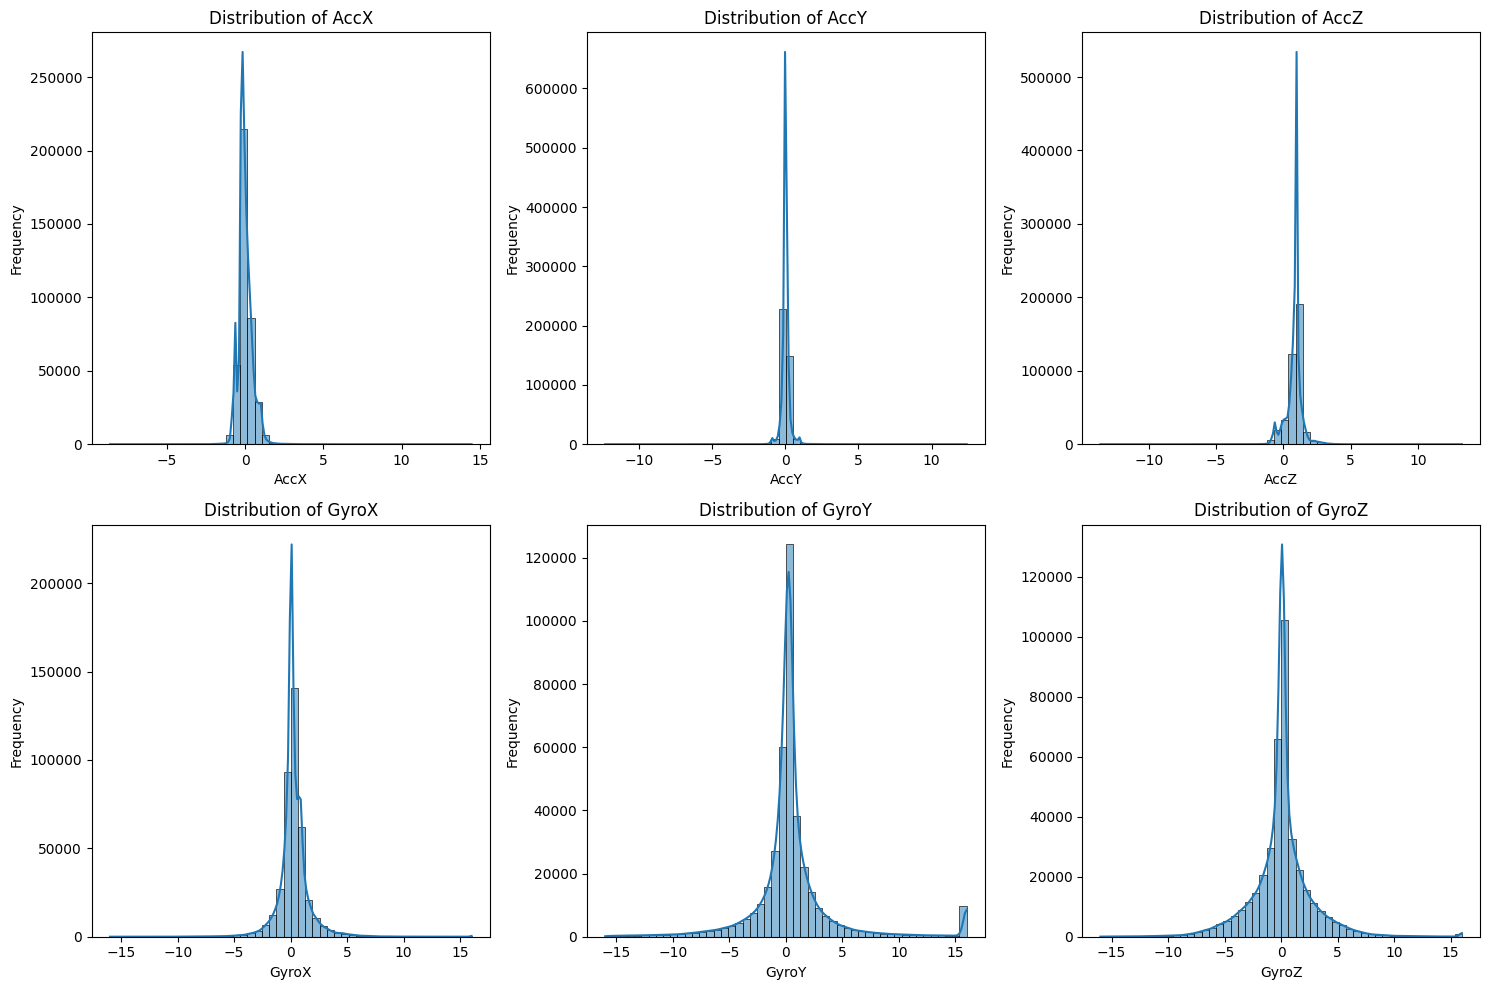

In [ ]:
# Visualize distribution of key sensor features
feature_columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
plt.figure(figsize=(15, 10))
for i, col in enumerate(feature_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=df, x=col, kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Reasoning**:
Calculate and visualize the correlation matrix of the sensor features to understand the relationships between them. This will help in feature selection as requested in the main task, specifically focusing on AccX, AccY, AccZ, GyroX, GyroY, and GyroZ.



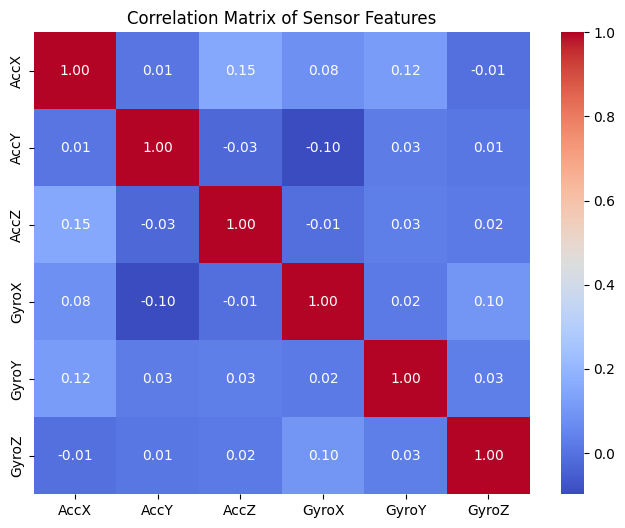

In [ ]:
# Calculate and visualize the correlation matrix
correlation_matrix = df[feature_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Sensor Features')
plt.show()